In [ ]:
# 꿀팀 : 퇴직 예측을 할때는 랜포는 별로고, 라이트GBM 성능이 좋았다.

In [51]:
# PACKAGE_BASIC
import pandas as pd
import numpy as np

# PACKAGE_VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns 

# PACKAGE_PREPROCESSING
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PACKAGE_MODELING
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# PACKAGE_EVALUATION
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import log_loss

In [2]:
# OPTION_JUPYTER
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [41]:
# LOAD dataset 
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sample = pd.read_csv('./data/sample_submission.csv')

In [4]:
# FUNCTION : 독립변수별 histogram 그리기
def draw_distplot(df):
    fig, ax = plt.subplots(6, 3, figsize=(36,36))

    sns.distplot(df['psfMag_u'], ax=ax[0][0])
    sns.distplot(df['fiberMag_u'], ax=ax[0][1])
    sns.distplot(df['petroMag_u'], ax=ax[0][2])

    sns.distplot(df['psfMag_g'], ax=ax[1][0])
    sns.distplot(df['fiberMag_g'], ax=ax[1][1])
    sns.distplot(df['petroMag_g'], ax=ax[1][2])

    sns.distplot(df['psfMag_r'], ax=ax[2][0])
    sns.distplot(df['fiberMag_r'], ax=ax[2][1])
    sns.distplot(df['petroMag_r'], ax=ax[2][2])

    sns.distplot(df['psfMag_i'], ax=ax[3][0])
    sns.distplot(df['fiberMag_i'], ax=ax[3][1])
    sns.distplot(df['petroMag_i'], ax=ax[3][2])

    sns.distplot(df['psfMag_z'], ax=ax[4][0])
    sns.distplot(df['fiberMag_z'], ax=ax[4][1])
    sns.distplot(df['petroMag_z'], ax=ax[4][2])

    sns.distplot(df['fiberID'], ax=ax[5][0])
    sns.barplot(x=df['type'].value_counts().index, y=df['type'].value_counts(), ax=ax[5][1])

    plt.tight_layout()
    plt.show()

In [19]:
# FUNCTION : pearson 상관관계 분석을 위한 heatmap 그리기
def draw_corr_heatmap(df):
    plt.figure(figsize=(15,12))
    corr = df.corr(method='pearson')
    sns.heatmap(data = corr, annot=True, fmt = '.2f', linewidths=.5, cmap='RdYlBu_r')
    plt.show()

In [9]:
# FUNCTION : 두 변수간 scatter map 그리기
def draw_scattermap(df, x, y):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x=x, y=y, s=30, hue='type', data=df)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [39]:
# FUNCTION : 각 독립변수의 OUTLIER 제거
def remove_outlier(df, column):
    df_d = df
    fraud_column_data = df[column]
    q_25 = np.percentile(fraud_column_data.values, 25)
    q_75 = np.percentile(fraud_column_data.values, 75)
    
    lqr = (q_75-q_25) * 1.5
    lowest = q_25 - lqr
    highest = q_75 + lqr
    outlier_idx = fraud_column_data[(fraud_column_data < lowest)|(fraud_column_data > highest)].index
    df_d.drop(outlier_idx, axis=0, inplace=True)
    
    print('제거된 row수 : ' + str(len(outlier_idx)) + ' / 결과 row수 : ' + str(df_d.shape))
    return df_d

def remove_outlier2(df, column, target):
    df_d = df
    fraud_column_data = df.loc[df['type'] == target][column]
    q_25 = np.percentile(fraud_column_data.values, 25)
    q_75 = np.percentile(fraud_column_data.values, 75)
    
    lqr = (q_75-q_25) * 1.5
    lowest = q_25 - lqr
    highest = q_75 + lqr
    outlier_idx = fraud_column_data[(fraud_column_data < lowest)|(fraud_column_data > highest)].index
    df_d.drop(outlier_idx, axis=0, inplace=True)
    
    print('제거된 row수 : ' + str(len(outlier_idx)) + ' / 결과 row수 : ' + str(df_d.shape))
    return df_d

In [28]:
# FUNCTION : 모델 훈련 예측
def model_pred(classifier, X, Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)
    
    classifier.fit(x_train, y_train)
    
    y_train_pred = classifier.predict(x_train)
    y_test_pred = classifier.predict(x_test)
    
    evaluate_pred('train data', y_train, y_train_pred)
    evaluate_pred('test data' ,y_test, y_test_pred)

In [62]:
def evaluate_pred(title, y, y_pred):
    accuracy =  accuracy_score(y, y_pred)
    precision =  precision_score(y, y_pred, average='macro')
    recall =  recall_score(y, y_pred, average='macro')
    # f1 =  f1_score(y, y_pred, average='macro')
    # roc = roc_auc_score(y, y_pred, average='macro')
    print('--------------+' + str(title) + '+--------------')
    print('정확도 : {0:.3f}, 정밀도 : {1:.3f}, 재현율 : {2:.3f}'.format(accuracy, precision, recall))
    # print('f1-score : {0:.3f}, auc : {1:.3f}').format(f1, roc)

In [49]:
# make RESULT to SUBMIT CSV FILE
def make_CSV(df):
    df = df[['id','type']]
    result = pd.get_dummies(df, prefix='', prefix_sep='')
    result['SERENDIPITY_MANUAL']=0
    result['STAR_PN']=0
    result = result[['id', 'STAR_WHITE_DWARF', 'STAR_CATY_VAR', 'STAR_BROWN_DWARF', 'SERENDIPITY_RED', 'REDDEN_STD', 'STAR_BHB', 'GALAXY', 'SERENDIPITY_DISTANT', 'QSO', 'SKY', 'STAR_RED_DWARF', 'ROSAT_D', 'STAR_PN', 'SERENDIPITY_FIRST', 'STAR_CARBON', 'SPECTROPHOTO_STD', 'STAR_SUB_DWARF', 'SERENDIPITY_MANUAL', 'SERENDIPITY_BLUE']]
    return result

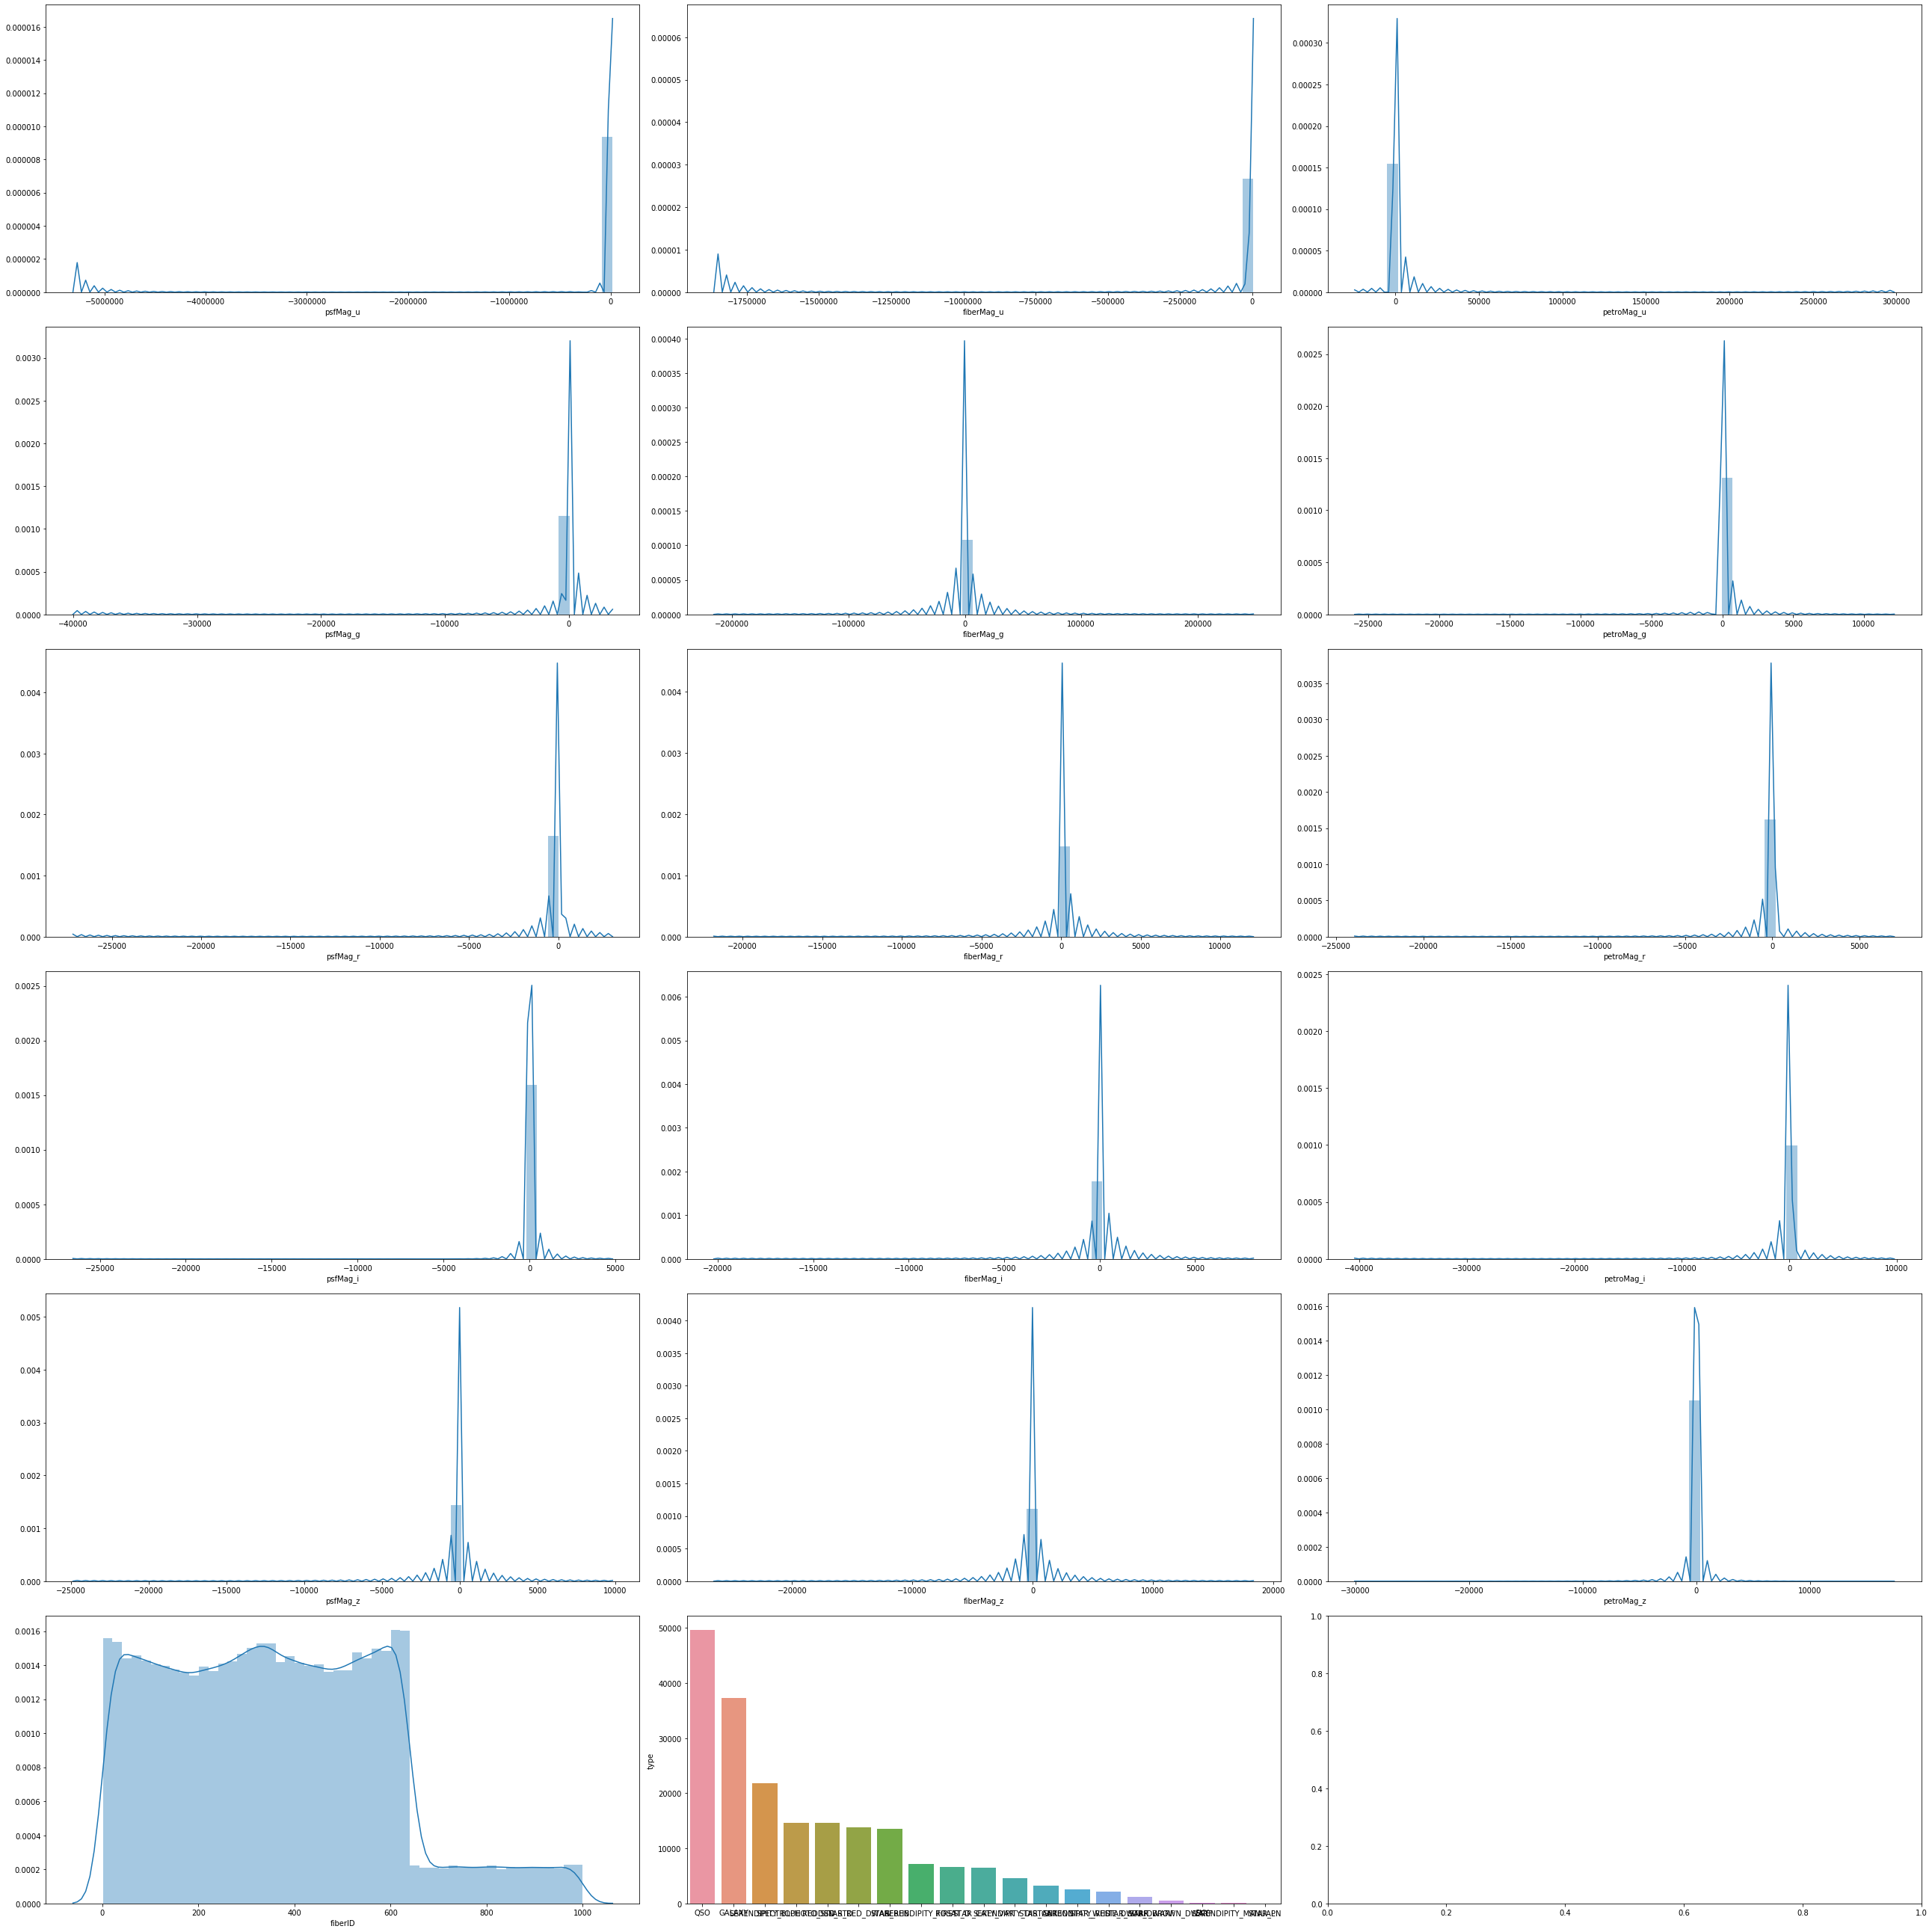

In [21]:
# 1. 변수들의 HISTOGRAM을 통해 분포 확인하기
draw_distplot(train)

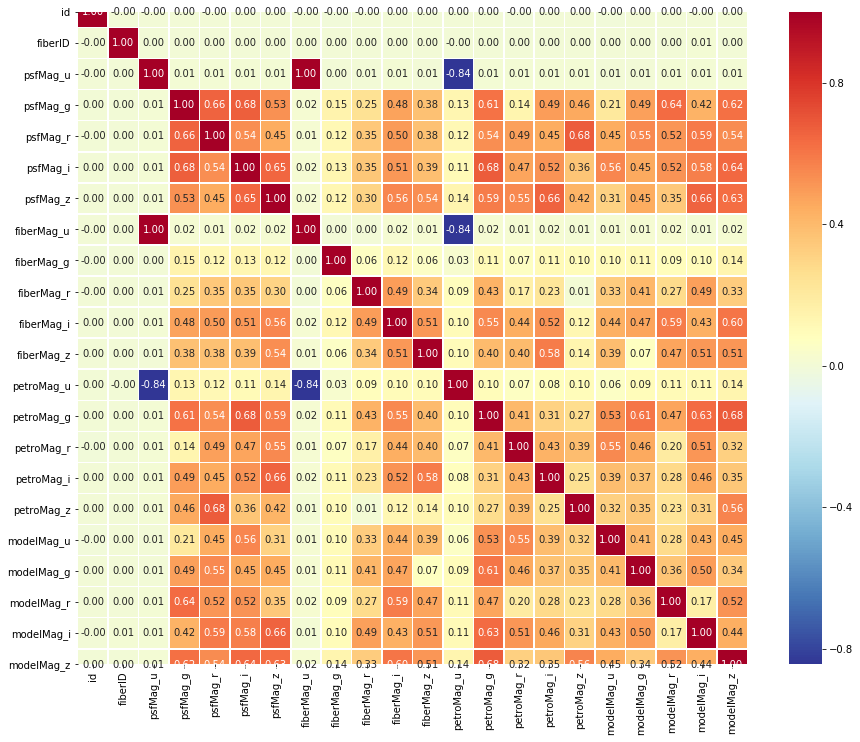

In [20]:
# 변수 별 상관관계 확인하기
draw_corr_heatmap(train)

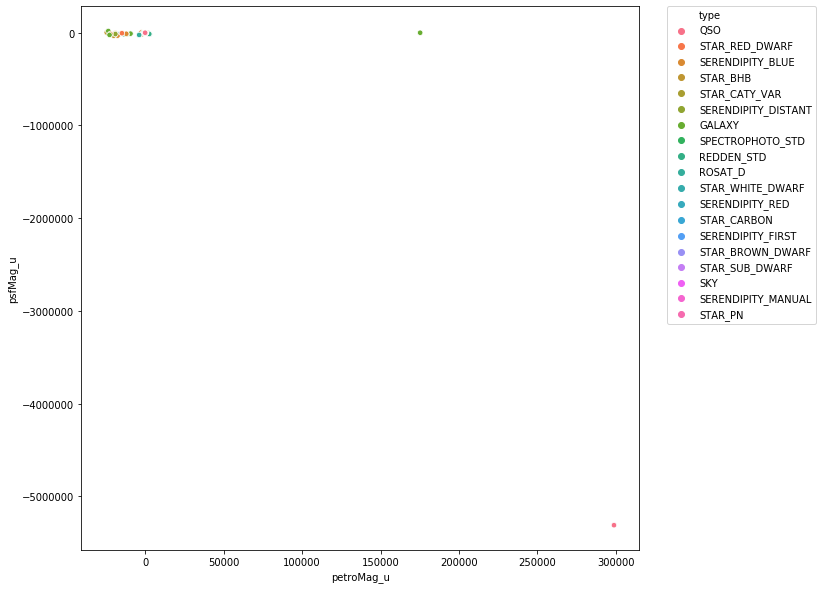

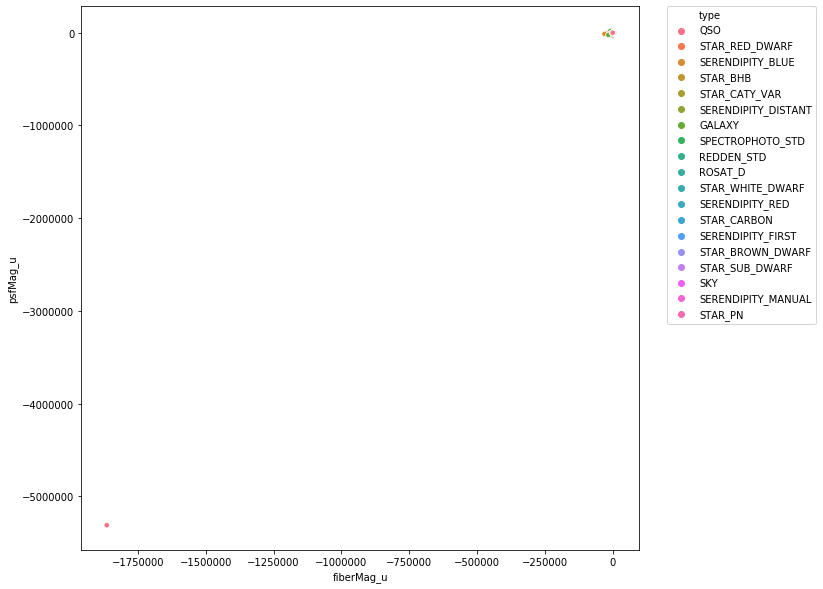

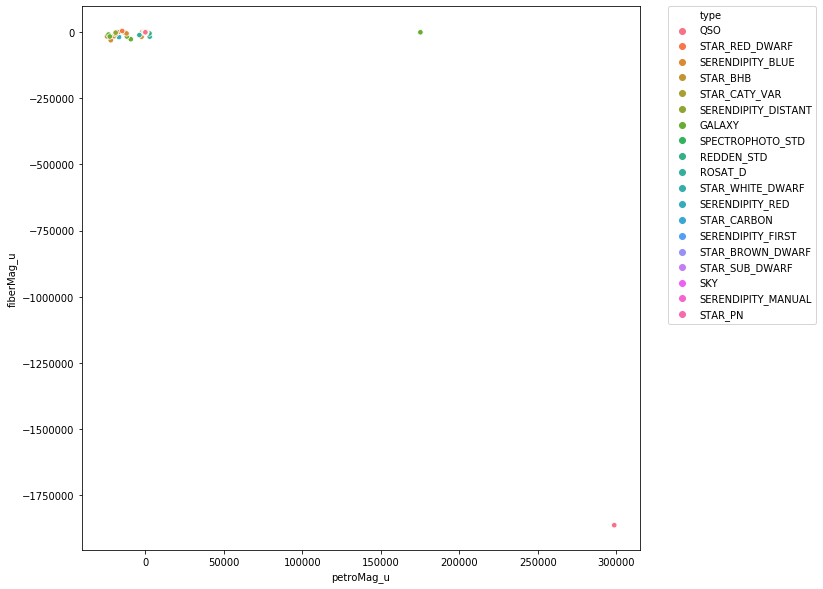

In [26]:
# 강한 상관관계를 가진 petroMag_u-psfMag_u / fiberMag_u-psfMag_u / fiberMag_u-petroMag_u 의 scatter map 보기
draw_scattermap(train, 'petroMag_u', 'psfMag_u')
draw_scattermap(train, 'fiberMag_u', 'psfMag_u')
draw_scattermap(train, 'petroMag_u', 'fiberMag_u')

In [37]:
train.columns

Index(['id', 'type', 'fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z'], dtype='object')

In [42]:
# 각 변수별 이상치 제거하기
train_R = train
train_R = remove_outlier(train_R, 'psfMag_u')
train_R = remove_outlier(train_R, 'psfMag_g')
train_R = remove_outlier(train_R, 'psfMag_r')
train_R = remove_outlier(train_R, 'psfMag_i')
train_R = remove_outlier(train_R, 'psfMag_z')

train_R = remove_outlier(train_R, 'fiberMag_u')
train_R = remove_outlier(train_R, 'fiberMag_g')
train_R = remove_outlier(train_R, 'fiberMag_r')
train_R = remove_outlier(train_R, 'fiberMag_i')
train_R = remove_outlier(train_R, 'fiberMag_z')

train_R = remove_outlier(train_R, 'petroMag_u')
train_R = remove_outlier(train_R, 'petroMag_g')
train_R = remove_outlier(train_R, 'petroMag_r')
train_R = remove_outlier(train_R, 'petroMag_i')
train_R = remove_outlier(train_R, 'petroMag_z')

train_R = remove_outlier(train_R, 'modelMag_u')
train_R = remove_outlier(train_R, 'modelMag_g')
train_R = remove_outlier(train_R, 'modelMag_r')
train_R = remove_outlier(train_R, 'modelMag_i')
train_R = remove_outlier(train_R, 'modelMag_z')

제거된 row수 : 2909 / 결과 row수 : (197082, 23)
제거된 row수 : 1368 / 결과 row수 : (195714, 23)
제거된 row수 : 208 / 결과 row수 : (195506, 23)
제거된 row수 : 86 / 결과 row수 : (195420, 23)
제거된 row수 : 191 / 결과 row수 : (195229, 23)
제거된 row수 : 2368 / 결과 row수 : (192861, 23)
제거된 row수 : 519 / 결과 row수 : (192342, 23)
제거된 row수 : 50 / 결과 row수 : (192292, 23)
제거된 row수 : 12 / 결과 row수 : (192280, 23)
제거된 row수 : 104 / 결과 row수 : (192176, 23)
제거된 row수 : 7611 / 결과 row수 : (184565, 23)
제거된 row수 : 723 / 결과 row수 : (183842, 23)
제거된 row수 : 92 / 결과 row수 : (183750, 23)
제거된 row수 : 252 / 결과 row수 : (183498, 23)
제거된 row수 : 1042 / 결과 row수 : (182456, 23)
제거된 row수 : 2741 / 결과 row수 : (179715, 23)
제거된 row수 : 110 / 결과 row수 : (179605, 23)
제거된 row수 : 1 / 결과 row수 : (179604, 23)
제거된 row수 : 4 / 결과 row수 : (179600, 23)
제거된 row수 : 5 / 결과 row수 : (179595, 23)


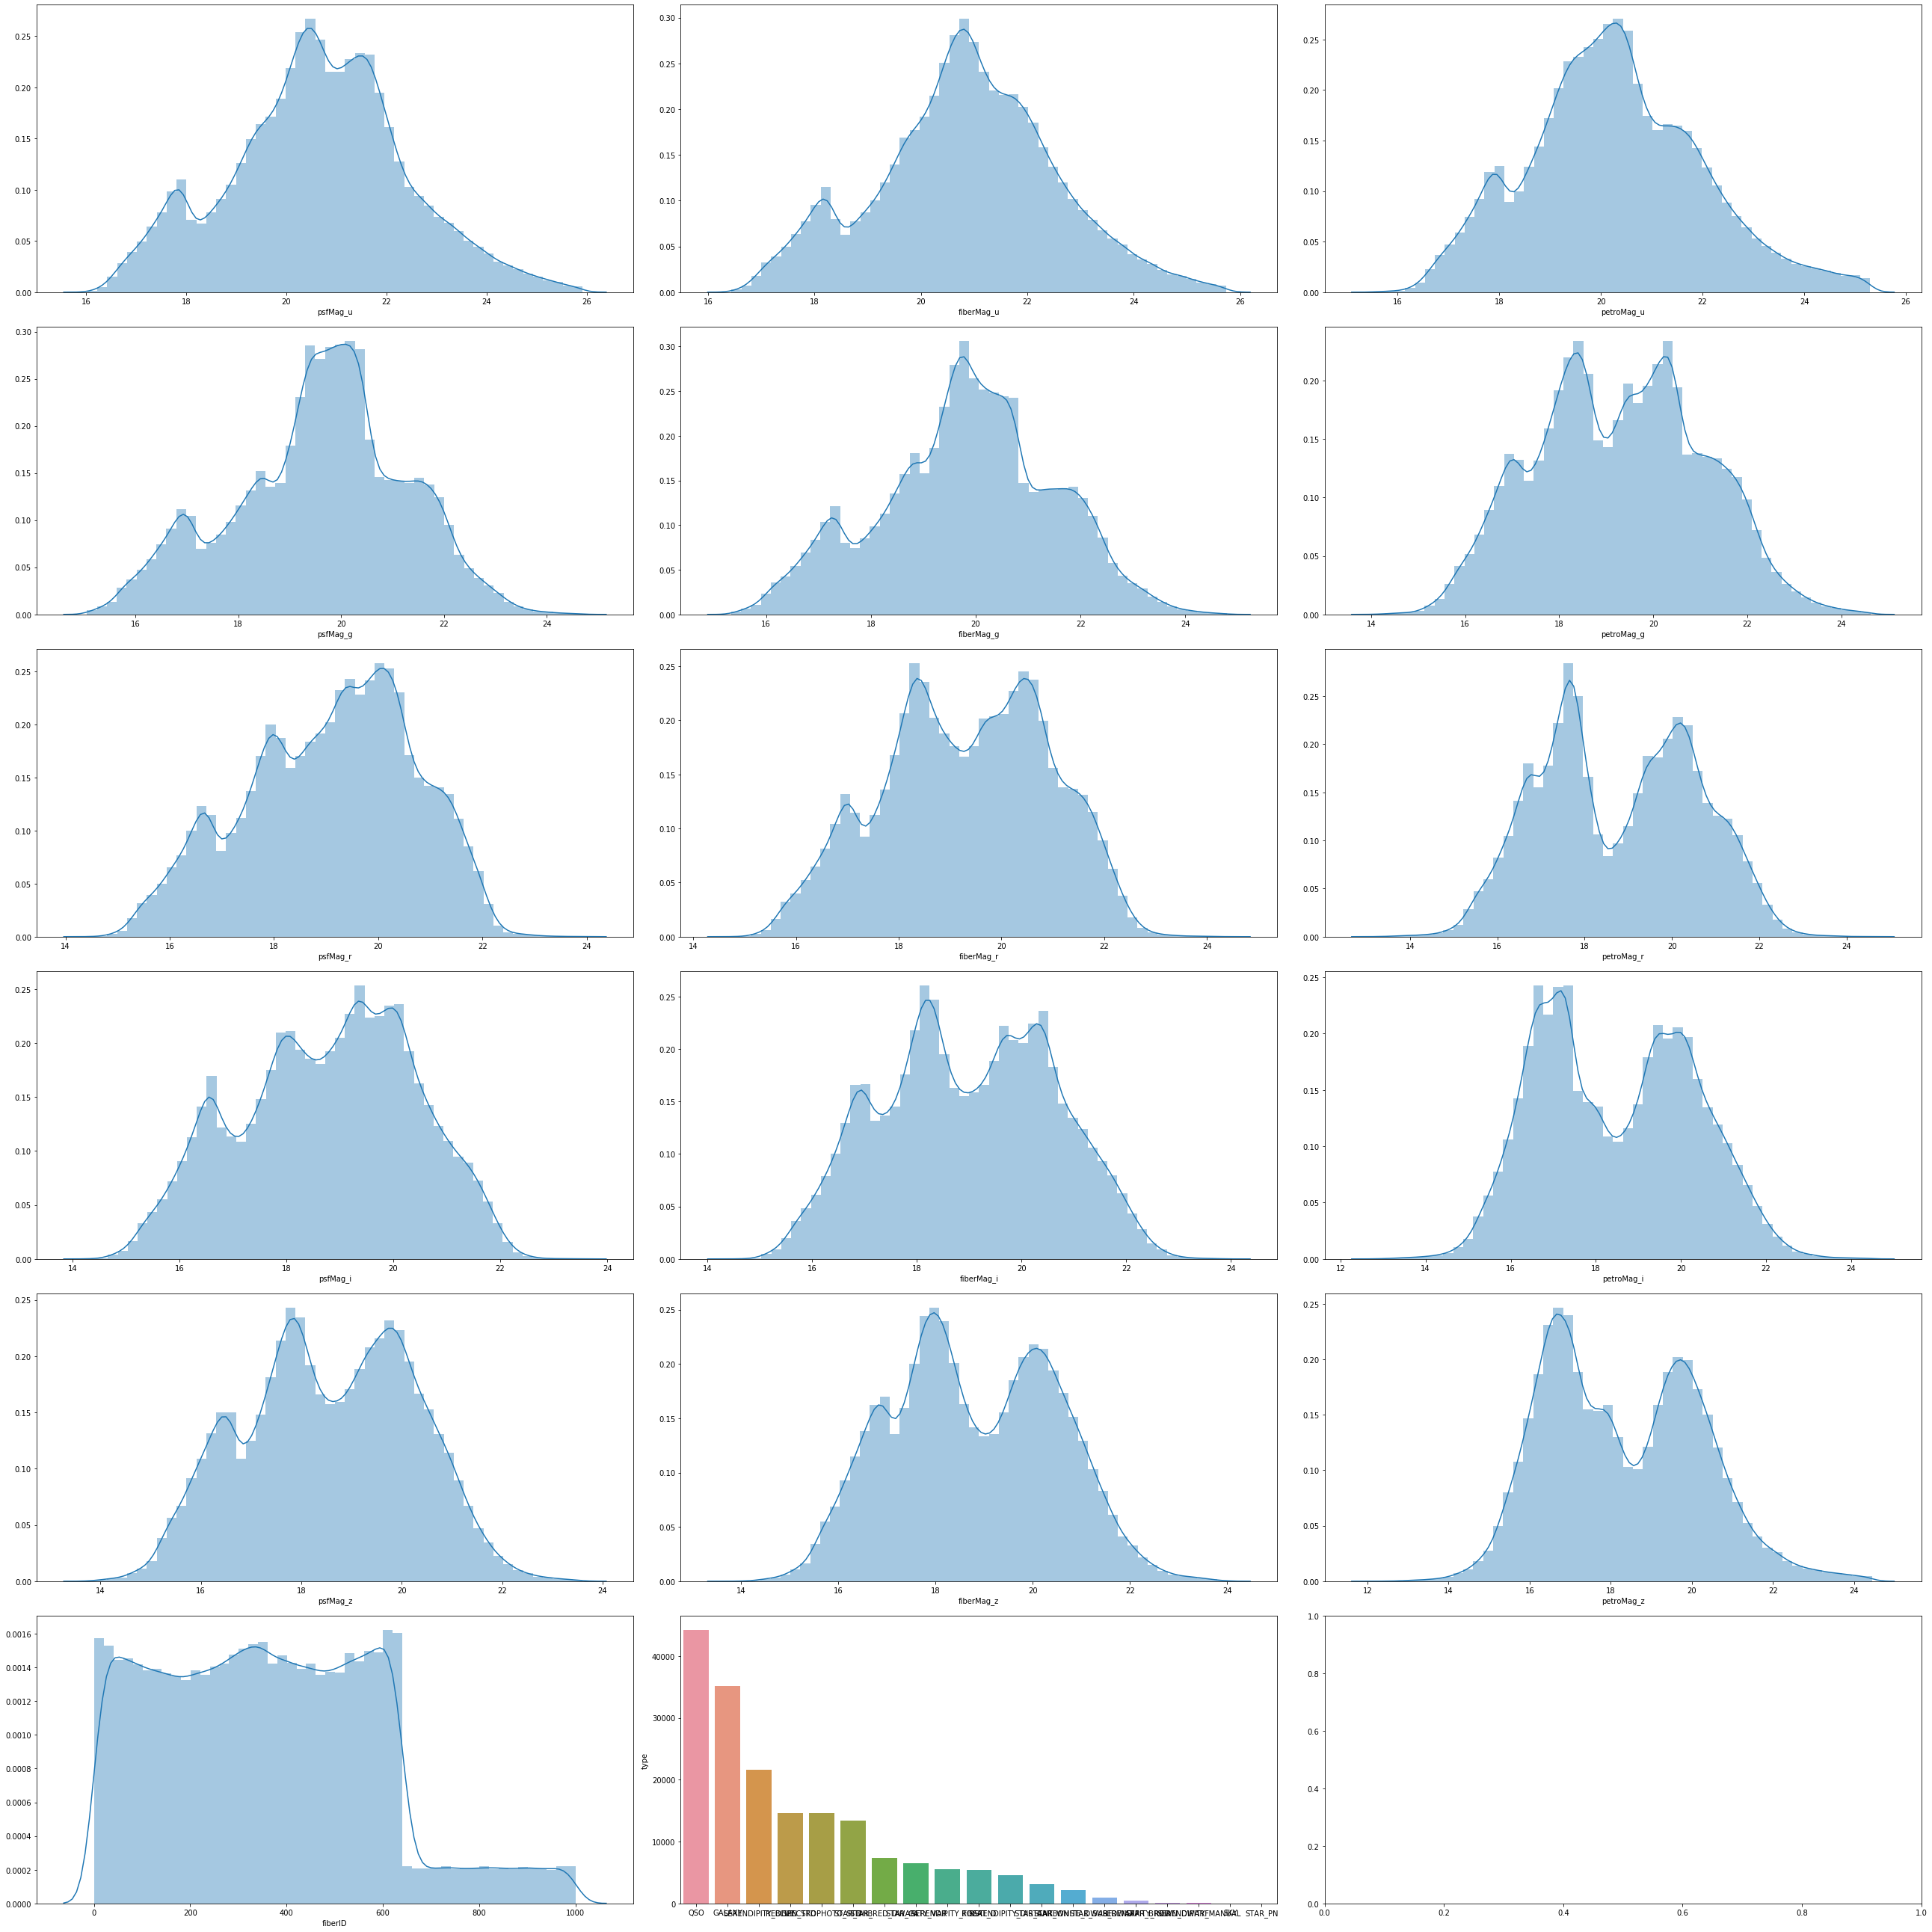

In [46]:
# 이상치 제거 후 Histogram
draw_distplot(train_R)

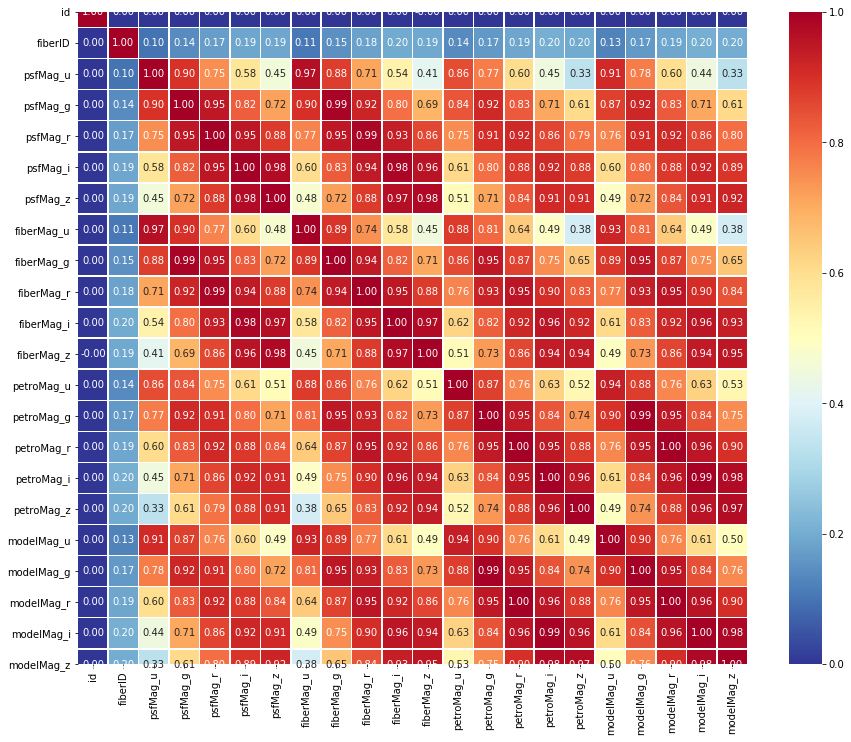

In [43]:
# 변수 별 상관관계 확인하기
draw_corr_heatmap(train_R)

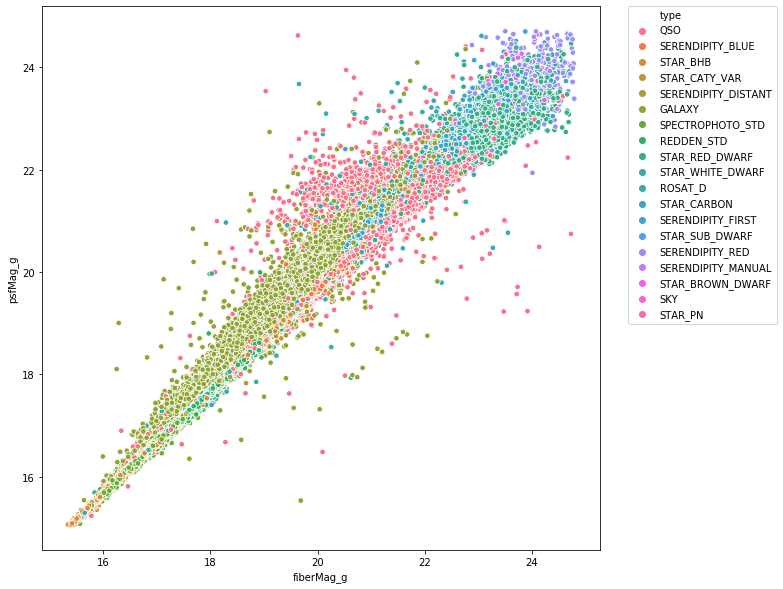

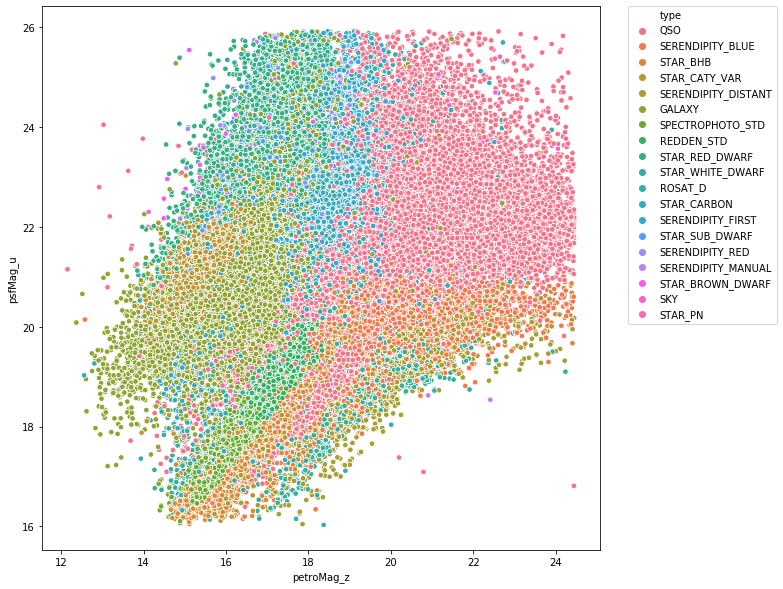

In [48]:
draw_scattermap(train_R, 'fiberMag_g', 'psfMag_g')
draw_scattermap(train_R, 'petroMag_z', 'psfMag_u')

In [76]:
X = train_R[['fiberID', 'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']]
Y = train_R['type']

In [77]:
model_tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=12)
model_pred(model_tree, X, Y)

--------------+train data+--------------
정확도 : 0.885, 정밀도 : 0.865, 재현율 : 0.776
--------------+test data+--------------
정확도 : 0.847, 정밀도 : 0.636, 재현율 : 0.631


In [79]:
model_forest = RandomForestClassifier(n_estimators=10, n_jobs=4)
model_pred(model_forest, X, Y)

--------------+train data+--------------
정확도 : 0.992, 정밀도 : 0.995, 재현율 : 0.978
--------------+test data+--------------
정확도 : 0.865, 정밀도 : 0.783, 재현율 : 0.651


In [ ]:
model_ada = AdaBoostClassifier(base_estimator=model_tree, n_estimators=10, learning_rate=0.1, random_state=1)
model_pred(model_ada, X, Y)

In [ ]:
train_nIDX = train_NoutL_t.drop(['id','type'], axis=1)
train_nIDX['fiberID'] = train_nIDX['fiberID'].astype(str)
train_ohe = pd.get_dummies(train_nIDX, prefix='', prefix_sep='')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [ ]:
set(test_ohe.columns.array) - set(train_ohe.columns.array)

In [ ]:
col_add = set(train_ohe.columns.array) - set(test_ohe.columns.array)
test_ohe_f = pd.concat([test_ohe, pd.DataFrame(columns = col_add)]) 
test_ohe_f = test_ohe_f.fillna(0.0)

In [ ]:
from sklearn.metrics import log_loss

log_loss(y_test, y_test_pred, eps=1e-15)